In [1]:
#importing all packages like LASSO, Relief, bagging, boosting, random forest etc
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import os
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [13]:
#class labels
labels = ['Black_rot', 'Esca_(Black_Measles)', 'Healthy', 'Leaf_blight_(Isariopsis_Leaf_Spot)']
#function to get class label ID
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index  

In [14]:
#function to identify disease part
def diseaseIdentification(image_path):
    img = cv2.imread(image_path) #read image
    ret,thresh = cv2.threshold(img,45,255,cv2.THRESH_BINARY)#apply thresholding
    dilate = cv2.dilate(thresh, None) #dilate image
    erode = cv2.erode(dilate, None)#apply erode technique
    hsv = cv2.cvtColor(erode,cv2.COLOR_BGR2HSV)#convert to HSV to get H image
    h = hsv[:, :, 0] #get H part from image
    ret,thresh1 = cv2.threshold(h,15,255,cv2.THRESH_BINARY)#apply thrshold again
    erode = cv2.cvtColor(erode,cv2.COLOR_BGR2GRAY)#convert image to gray format
    segmented = cv2.bitwise_and(erode, thresh1)#apply bitwise AND to get segmented disease part
    return segmented
#function to extract features from images
def featureExtraction(img):
    img = cv2.resize(img, (16, 16))
    img = img.ravel()
    return img

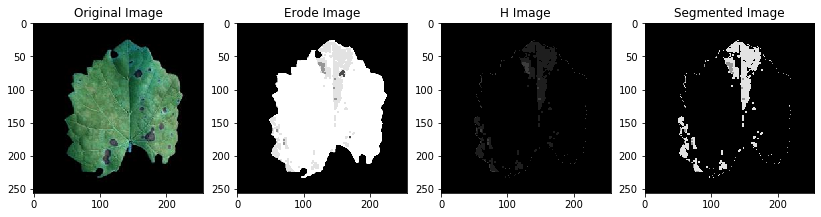

In [15]:
#display grabcut sample processed Image
def showProcessImage():
    #reading image
    img = cv2.imread("Dataset/Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376_final_masked.jpg")
    ret,thresh = cv2.threshold(img,45,255,cv2.THRESH_BINARY)#thresholding image
    dilate = cv2.dilate(thresh, None)#dilating image part
    erode = cv2.erode(dilate, None) #erosion image
    hsv = cv2.cvtColor(erode,cv2.COLOR_BGR2HSV)#converting to HSV
    h = hsv[:, :, 0] #taking h part from image
    ret,thresh1 = cv2.threshold(h,15,255,cv2.THRESH_BINARY)#again thresholding
    erode = cv2.cvtColor(erode,cv2.COLOR_BGR2GRAY)#color to gray conversion
    segmented = cv2.bitwise_and(erode, thresh1)#perfroming bitwise AND to get disease segmented part 
    #show images
    fig, axs = plt.subplots(1,4,figsize=(14, 6))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[1].imshow(cv2.cvtColor(erode,cv2.COLOR_BGR2RGB))
    axs[1].set_title("Erode Image")
    axs[2].imshow(cv2.cvtColor(h,cv2.COLOR_BGR2RGB))
    axs[2].set_title("H Image")
    axs[3].imshow(cv2.cvtColor(segmented,cv2.COLOR_BGR2RGB))
    axs[3].set_title("Segmented Image")
    plt.show()
showProcessImage()    

In [16]:
#load all images
if os.path.exists("model/X.txt.npy"): #if images already processed then load it
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if not process then process all images
    path = "Dataset"
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):#loop all images
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                disease_part = diseaseIdentification(root+"/"+directory[j])#xtract disease part
                img = featureExtraction(disease_part)#extract features
                X.append(img) #add features and labels to array
                label = getID(name)
                Y.append(label)
                X.append(img)
                Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
#images preprocessing such as normalization and shuffling
X = X.astype('float32') #converting images as float
X = X/255 #normalize all images
indices = np.arange(X.shape[0])#shuffle the images
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
print()
print("Image Preprocessing Completed")
print("Total Images found in dataset : "+str(X.shape[0]))


Image Preprocessing Completed
Total Images found in dataset : 8178


In [17]:
#splitting images to train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("(80%) Leaf images used for training : "+str(X_train.shape[0])) #print training and test size
print("(20%) Leaf images used for testing  : "+str(X_test.shape[0]))


Dataset train & test split as 80% dataset for training and 20% for testing
(80%) Leaf images used for training : 6542
(20%) Leaf images used for testing  : 1636


In [18]:
#defining global features to store accuracy and other values
accuracy = []
precision = []
recall = [] 
fscore = []

In [19]:
#function which will calculate all metrics and plot confusion matrix
def calculateMetrics(algorithm, y_test, predict):
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    a = accuracy_score(y_test,predict)*100  
    conf_matrix = confusion_matrix(y_test, predict) 
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+' Accuracy    : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FScore      : '+str(f)+"\n")
    print(classification_report(y_test,predict, target_names=labels))
    
    plt.figure(figsize =(6, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()  

SVM Accuracy    : 91.01466992665037
SVM Precision   : 90.36984084206425
SVM Recall      : 91.33891256769125
SVM FScore      : 90.76546959653122

                                    precision    recall  f1-score   support

                         Black_rot       0.88      0.92      0.90       460
              Esca_(Black_Measles)       0.92      0.93      0.93       557
                           Healthy       0.87      0.94      0.90       158
Leaf_blight_(Isariopsis_Leaf_Spot)       0.95      0.87      0.91       461

                          accuracy                           0.91      1636
                         macro avg       0.90      0.91      0.91      1636
                      weighted avg       0.91      0.91      0.91      1636



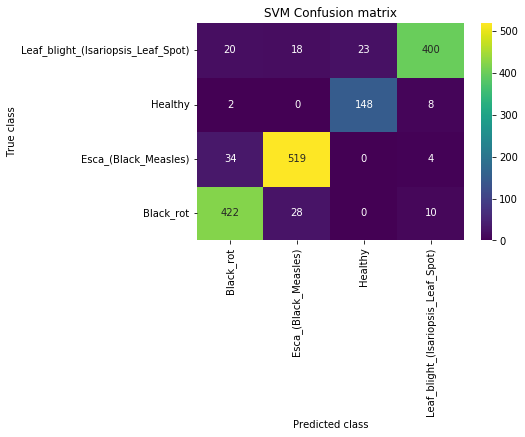

In [20]:
#now train SVM on 80% training data and perform prediction on 20% test data to calculate prediction accuracy
svm_cls = svm.SVC(C=80)
svm_cls.fit(X_train, y_train)
predict = svm_cls.predict(X_test)
calculateMetrics("SVM", y_test, predict)

Random Forest Accuracy    : 87.22493887530563
Random Forest Precision   : 88.72535949805098
Random Forest Recall      : 87.6201847023244
Random Forest FScore      : 88.11320331529188

                                    precision    recall  f1-score   support

                         Black_rot       0.79      0.85      0.82       460
              Esca_(Black_Measles)       0.88      0.88      0.88       557
                           Healthy       0.95      0.90      0.93       158
Leaf_blight_(Isariopsis_Leaf_Spot)       0.92      0.87      0.90       461

                          accuracy                           0.87      1636
                         macro avg       0.89      0.88      0.88      1636
                      weighted avg       0.87      0.87      0.87      1636



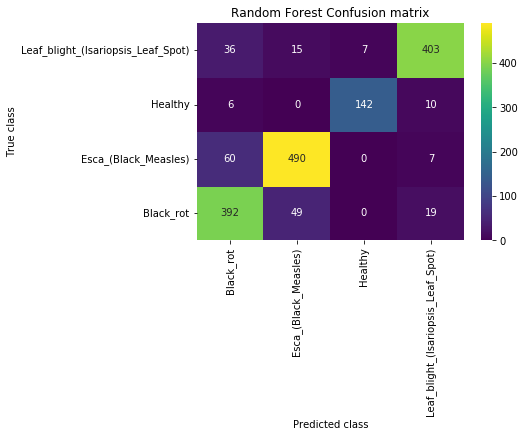

In [21]:
#now train Random Forest on 80% training data and perform prediction on 20% test data to calculate prediction accuracy
rf_cls = RandomForestClassifier(n_estimators=8)
rf_cls.fit(X_train, y_train)
predict = rf_cls.predict(X_test)
calculateMetrics("Random Forest", y_test, predict)

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoost Accuracy    : 54.706601466992666
AdaBoost Precision   : 41.01706472062509
AdaBoost Recall      : 45.549518860130874
AdaBoost FScore      : 42.53814172612813

                                    precision    recall  f1-score   support

                         Black_rot       0.42      0.43      0.42       460
              Esca_(Black_Measles)       0.68      0.58      0.62       557
                           Healthy       0.00      0.00      0.00       158
Leaf_blight_(Isariopsis_Leaf_Spot)       0.55      0.81      0.66       461

                          accuracy                           0.55      1636
                         macro avg       0.41      0.46      0.43      1636
                      weighted avg       0.50      0.55      0.52      1636



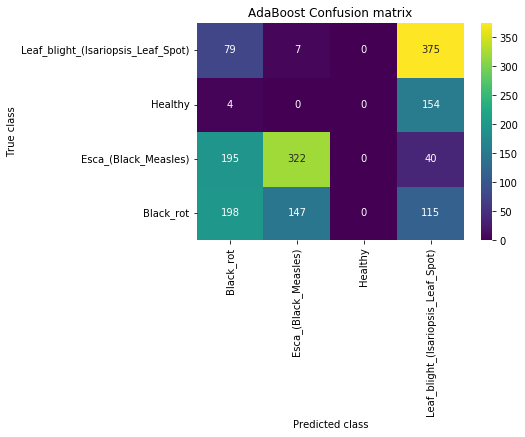

In [22]:
#now train AdaBoost on 80% training data and perform prediction on 20% test data to calculate prediction accuracy
ada_cls = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ada_cls.fit(X_train, y_train)
predict = ada_cls.predict(X_test)
calculateMetrics("AdaBoost", y_test, predict)

XGBoost Accuracy    : 93.76528117359413
XGBoost Precision   : 94.36459179172962
XGBoost Recall      : 93.70472236949695
XGBoost FScore      : 94.02486802096216

                                    precision    recall  f1-score   support

                         Black_rot       0.91      0.92      0.92       460
              Esca_(Black_Measles)       0.94      0.95      0.94       557
                           Healthy       0.97      0.94      0.95       158
Leaf_blight_(Isariopsis_Leaf_Spot)       0.95      0.94      0.95       461

                          accuracy                           0.94      1636
                         macro avg       0.94      0.94      0.94      1636
                      weighted avg       0.94      0.94      0.94      1636



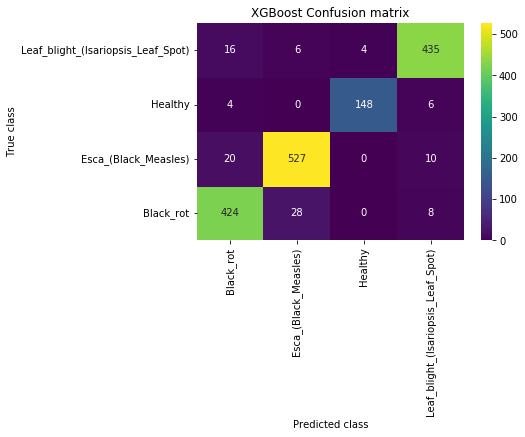

In [27]:
#now training advance machine learning XGBOOST algortihm on train dataset and then testing on test data
xg_cls = XGBClassifier(n_estimators=350, base_score=0.1,max_depth=20) 
xg_cls.fit(X_train, y_train)
predict = xg_cls.predict(X_test)
calculateMetrics("XGBoost", y_test, predict)

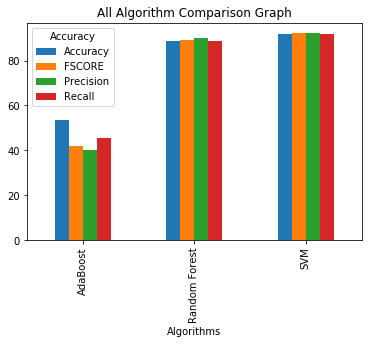

In [24]:
df = pd.DataFrame([['SVM','Accuracy',accuracy[0]],['SVM','Precision',precision[0]],['SVM','Recall',recall[0]],['SVM','FSCORE',fscore[0]],
                   ['Random Forest','Accuracy',accuracy[1]],['Random Forest','Precision',precision[1]],['Random Forest','Recall',recall[1]],['Random Forest','FSCORE',fscore[1]],
                   ['AdaBoost','Accuracy',accuracy[2]],['AdaBoost','Precision',precision[2]],['AdaBoost','Recall',recall[2]],['AdaBoost','FSCORE',fscore[2]],
                   ['XGBoost','Accuracy',accuracy[3]],['XGBoost','Precision',precision[3]],['XGBoost','Recall',recall[3]],['XGBoost','FSCORE',fscore[3]],
                  ],columns=['Algorithms','Accuracy','Value'])
df.pivot("Algorithms", "Accuracy", "Value").plot(kind='bar')
plt.title("All Algorithm Comparison Graph")
plt.show()

In [25]:
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["SVM", "Random Forest", "AdaBoost", 'XGBoost']
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,SVM,92.239972,91.903056,92.057969,91.931540
1,Random Forest,90.212944,88.731475,89.372090,88.630807
2,AdaBoost,40.289705,45.703420,41.745042,53.667482


In [31]:
def predict(img_path):
    disease_part = diseaseIdentification(img_path)#xtract disease part
    img = featureExtraction(disease_part)#extract features
    test = []
    test.append(img) #add features and labels to array
    test = np.asarray(test)
    test = test.astype('float32') #converting images as float
    test = test/255 #normalize all images
    predict = int(svm_cls.predict(test))
    return labels[predict]

In [ ]:
from flask import Flask, render_template, request, redirect, url_for, session
from werkzeug.utils import secure_filename

app = Flask(__name__)
app.secret_key = 'welcome'

@app.route('/index', methods=['GET', 'POST'])
def index():
    return render_template('index.html', msg='')

@app.route('/Upload', methods=['GET', 'POST'])
def Upload():
    return render_template('Upload.html', msg='')

@app.route('/UploadAction', methods=['GET', 'POST'])
def UploadAction():
    if request.method == 'POST':
        file1 = request.files['t1']
        if os.path.exists("static/leaf.jpg"):
            os.remove("static/leaf.jpg")
        path = "static/leaf.jpg"
        file1.save(path)
        predictDisease = predict("static/leaf.jpg") 
        img = cv2.imread("static/leaf.jpg")
        img = cv2.resize(img, (600,400))
        cv2.putText(img, 'Predicted Disease : '+predictDisease, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
        cv2.imshow('Predicted Disease : '+predictDisease, img)
        cv2.waitKey(0)
        return render_template('Upload.html', msg='Predicted Disease : '+predictDisease)
if __name__ == '__main__':
    app.run()        

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Feb/2023 13:51:13] "GET /index HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:14] "GET /static/templatemo_style.css HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:14] "GET /static/tra.jpg HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:15] "GET /static/images/templatemo_header_repeat.jpg HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:15] "GET /static/images/templatemo_header_bg.jpg HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:15] "GET /static/images/templatemo_menu_bg.jpg HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:16] "GET /static/images/templatemo_content_top.jpg HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:47] "GET /static/images/templatemo_menu_right.jpg HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2023 13:51:47] "GET /Upload HTTP/1.1" 200 -


Esca_(Black_Measles)


127.0.0.1 - - [19/Feb/2023 13:52:57] "POST /UploadAction HTTP/1.1" 200 -


Healthy


127.0.0.1 - - [19/Feb/2023 13:53:54] "POST /UploadAction HTTP/1.1" 200 -


Leaf_blight_(Isariopsis_Leaf_Spot)


127.0.0.1 - - [19/Feb/2023 13:54:37] "POST /UploadAction HTTP/1.1" 200 -
